Install and Import libraries

In [1]:
!pip install fredapi matplotlib plotly keras keras-tuner --upgrade 
!pip install yfinance==0.1.70

from fredapi import Fred
import yfinance as yf

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Input
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping
import time
from matplotlib.ticker import MaxNLocator

2025-01-04 19:19:47.994045: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Function to create get stock data

In [2]:
# Function to fetch and process data
def getData(ticker_symbol, startday, endday):
    """
    Fetches stock data and various economic indicators, processes them, and saves the combined data to a CSV file.
    Args:
    ticker_symbol (str): The ticker symbol of the stock to download data for.
    startday (str): The start date for the data in 'YYYY-MM-DD' format.
    endday (str): The end date for the data in 'YYYY-MM-DD' format.
    Returns:
    pd.DataFrame: A DataFrame containing the stock data and economic indicators.
    """
    stock_data = yf.download(ticker_symbol, start=startday, end=endday)
    stock_data['Daily_Return'] = stock_data['Close'].pct_change() * 100
    
    fred = None
    #fred = Fred(api_key='YOUR_API_KEY') #UNCOMMENT THIS AND ADD YOUT API KEY FROM FRED
    if fred is not None:
        CPI = fred.get_series('MEDCPIM158SFRBCLE', observation_start=startday)
        M30US = fred.get_series('MORTGAGE30US', observation_start=startday)
        UNRA = fred.get_series('UNRATE', observation_start=startday)
        SP500 = fred.get_series('SP500', observation_start=startday)
        NEWH = fred.get_series('HOUST', observation_start=startday)
        NASDAQ = fred.get_series('NASDAQCOM', observation_start=startday)
        CARSA = fred.get_series('TOTALSA', observation_start=startday)

        df = pd.concat([SP500, CPI, M30US, UNRA, NEWH, NASDAQ, CARSA], axis=1)
        data_names = ['SP500', 'CPI', 'M30US', 'UNRA', 'NEWH', 'NASDAQ', 'CARSA']
        df.columns = data_names

    df = df.bfill()
    stock_data = stock_data.bfill()
    df = pd.concat((stock_data, df), axis=1)
    df.dropna(inplace=True)
    df.to_csv('data.csv', index=False)

    return df

Function to create sequences

In [3]:
# Function to create sequences
def create_sequences_with_date(data, seq_length, target_col, nextdays, date):
    datepred = date[-nextdays:]
    date = date[seq_length-1:-nextdays]
    X, y = [], []
    data = pd.DataFrame(data)  # Convert the data to a DataFrame for column referencing
    for i in range(len(data) - seq_length - nextdays + 1):
        X.append(data.iloc[i:i+seq_length, :].values)  # Use all columns as input
        y_sequence = [data.iloc[i+seq_length+j, target_col] for j in range(nextdays)]
        y.append(y_sequence)
        
    return np.array(X), np.array(y), date, datepred

Create the data

In [4]:
# Load and preprocess data
dataog = getData('BAC', '2022-01-01', '2023-11-05')
data = dataog

# Parameters
seq_length = 3
target_coln = 'Close'
dayspan = 10
nextdays = 5

# Get target column index and date index
target_col = data.columns.get_loc(target_coln)
date = data.index

# Initialize scalers
scalerinput = MinMaxScaler()
scaleroutput = MinMaxScaler()

# Fit scalers
orig = data[target_coln]
scaleroutput.fit(data[target_coln].values.reshape(-1, 1))
data = scalerinput.fit_transform(data)

# Create sequences
x, y, date, datepred = create_sequences_with_date(data, seq_length, target_col, nextdays, date)

# Print shapes of x and y
print(x.shape)
print(y.shape)

# Split data into train, validation, and test sets
testsize = int(np.round(x.shape[0] * .1))
trainsize = int(np.round((x.shape[0] - testsize) * .9))

x_train = x[:trainsize, :, :]
y_train = y[:trainsize, :]
x_val = x[trainsize:-testsize, :, :]
y_val = y[trainsize:-testsize, :]
x_test = x[-testsize:, :, :]
y_test = y[-testsize:, :]

[*********************100%***********************]  1 of 1 completed
(456, 3, 14)
(456, 5)


Size of X = (#days, #last days in previous window sequence, #stock data columns)

X = all column values for n previous days

Size of Y = (#days, #last days in next days window sequence)

Y = target column values for n next days

In [5]:
# Print shapes of train, validation, and test sets
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(369, 3, 14)
(369, 5)
(41, 3, 14)
(41, 5)
(46, 3, 14)
(46, 5)


Size of dates

In [6]:
# Get train, validation, and test dates
datetrain = date[:trainsize]
dateval = date[trainsize:-testsize]
datetest = date[-testsize:]

# Print shapes of date arrays
print('Trains days:',datetrain.shape[0])
print('Validation days:',dateval.shape[0])
print('Tests days:',datetest.shape[0])
print('Total days:',date.shape[0])
print('Total sum of days:',datetrain.shape[0] + dateval.shape[0] + datetest.shape[0])

Trains days: 369
Validation days: 41
Tests days: 46
Total days: 456
Total sum of days: 456


Plot train, valildation and test data

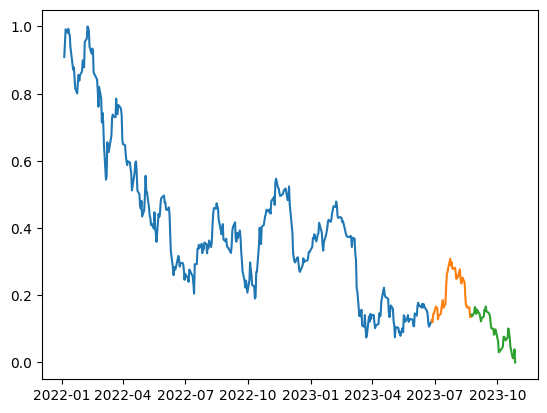

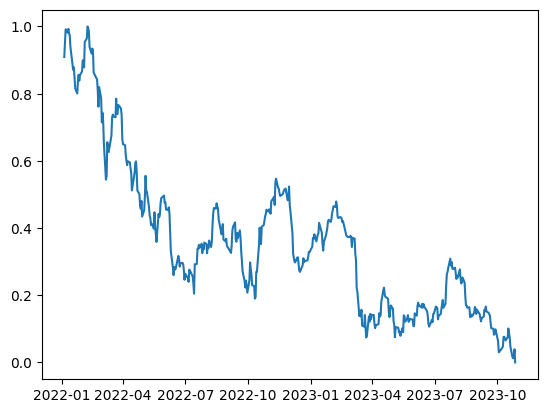

In [7]:
# Plot data
plt.plot(datetrain, x_train[:, -1, target_col])
plt.plot(dateval, x_val[:, -1, target_col])
plt.plot(datetest, x_test[:, -1, target_col])
plt.figure()
plt.plot(date[:], x[:, -1, target_col])

Create model

In [8]:
# Get time steps and total features
TimeSteps = x_train.shape[1]
TotalFeatures = x_train.shape[2]

# Define the regressor model
regressor = Sequential()
regressor.add(LSTM(units=32, activation='relu', input_shape=(TimeSteps, TotalFeatures)))
regressor.add(Dense(units=15, activation='relu'))
regressor.add(Dense(units=15, activation='relu'))
regressor.add(Dense(units=nextdays))

# Compile the regressor model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
regressor.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mean_absolute_error'])


/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train model with early stopping

In [9]:
# Train the regressor model with early stopping
early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)
history = regressor.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_val, y_val), verbose=0)

Plot model metrics

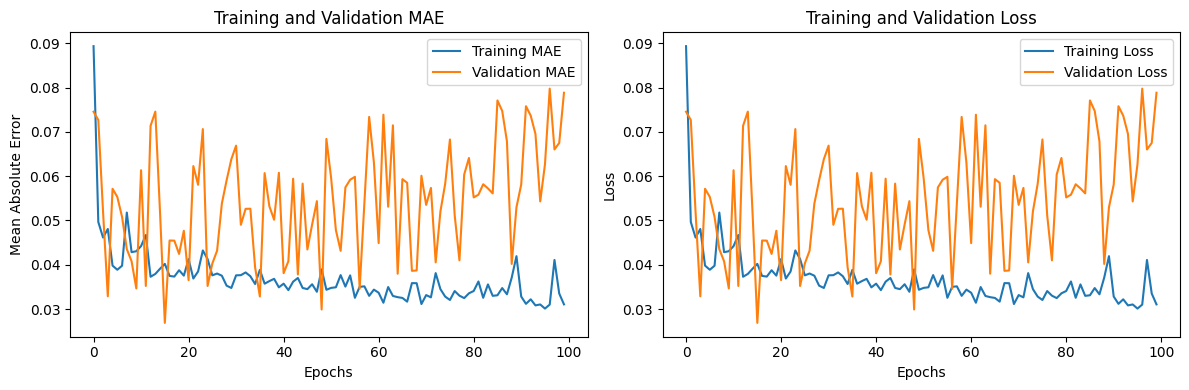

In [10]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot Training and Validation MAE
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Plot predicted vs real

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


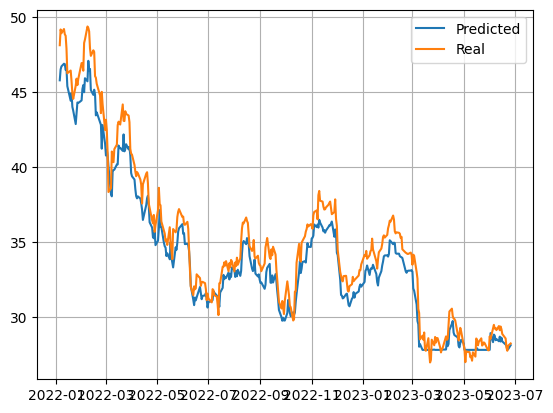

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


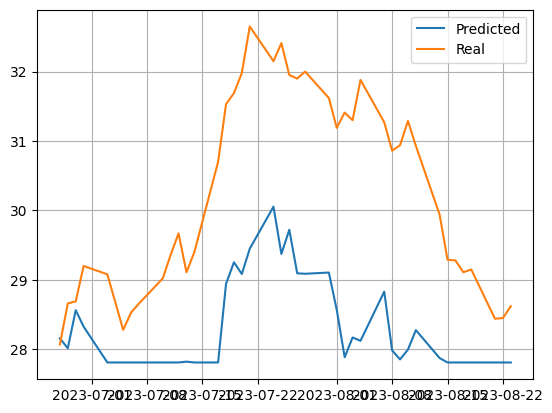

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


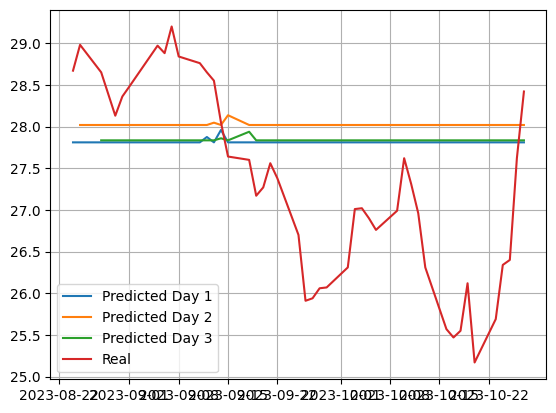

In [11]:
# Predict and inverse transform the training data
predicted_Price = regressor.predict(x_train)
predicted_Price = scaleroutput.inverse_transform(predicted_Price)

# Plot predicted vs real prices for training data
plt.figure()
plt.plot(datetrain, predicted_Price[:, 0], label='Predicted')
plt.plot(datetrain, scaleroutput.inverse_transform(y_train)[:, 0], label='Real')
plt.legend()
plt.grid()
plt.show()

# Predict and inverse transform the validation data
predicted_Price = regressor.predict(x_val)
predicted_Price = scaleroutput.inverse_transform(predicted_Price)

# Plot predicted vs real prices for validation data
plt.figure()
plt.plot(dateval, predicted_Price[:, 0], label='Predicted')
plt.plot(dateval, scaleroutput.inverse_transform(y_val)[:, 0], label='Real')
plt.legend()
plt.grid()
plt.show()

# Predict and inverse transform the test data
predicted_Price = regressor.predict(x_test)
predicted_Price = scaleroutput.inverse_transform(predicted_Price)

# Plot predicted vs real prices for test data
plt.figure()
plt.plot(datetest, predicted_Price[:, 0], label='Predicted Day 1')
plt.plot(datetest[1:], predicted_Price[:-1, 1], label='Predicted Day 2')
plt.plot(datetest[2:], predicted_Price[:-2, 2], label='Predicted Day 3')
plt.plot(datetest, scaleroutput.inverse_transform(y_test)[:, -1], label='Real')
plt.legend()
plt.grid()
plt.show()

Plot all data with predicted vs real

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


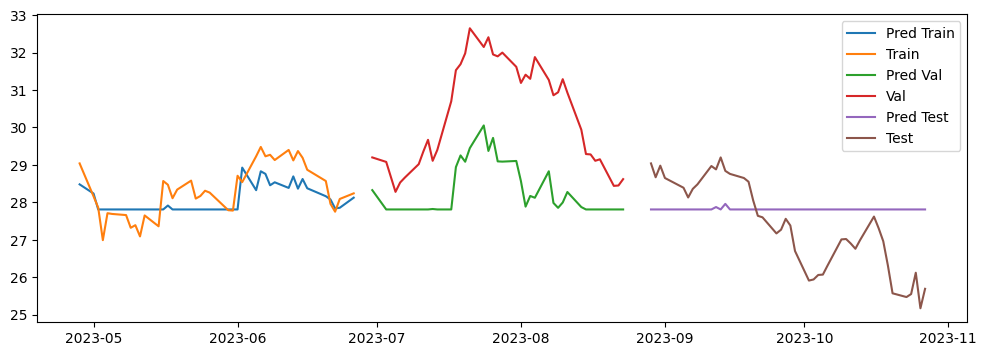

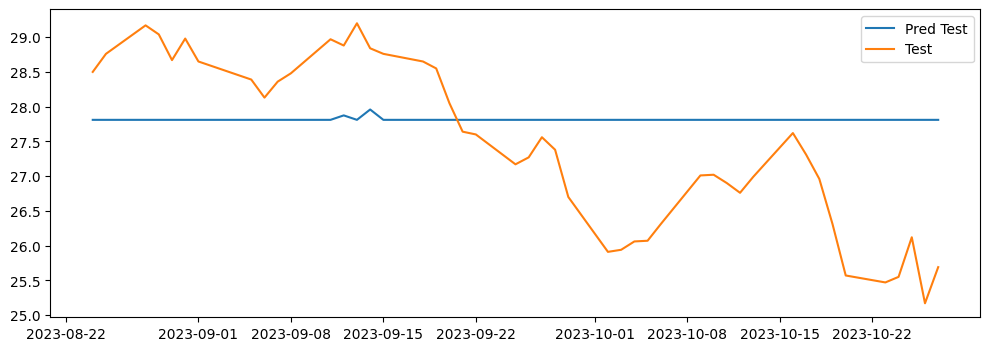

In [12]:
# Predict and plot training data
predicted_Price = scaleroutput.inverse_transform(regressor.predict(x_train))
orig = scaleroutput.inverse_transform(y_train)
plt.figure(figsize=(12, 4))
plt.plot(datetrain[-40:], predicted_Price[-40:,0], label='Pred Train')
plt.plot(datetrain[-40:], orig[-40:,0], label='Train')

# Predict and plot validation data
predicted_Price = scaleroutput.inverse_transform(regressor.predict(x_val))
orig = scaleroutput.inverse_transform(y_val)
plt.plot(dateval[seq_length:], predicted_Price[seq_length:,0], label='Pred Val')
plt.plot(dateval[seq_length:], orig[seq_length:,0], label='Val')

# Predict and plot test data
predicted_Price = scaleroutput.inverse_transform(regressor.predict(x_test))
orig = scaleroutput.inverse_transform(y_test)
plt.plot(datetest[seq_length:], predicted_Price[seq_length:,0], label='Pred Test')
plt.plot(datetest[seq_length:], orig[seq_length:,0], label='Test')

# Add legend and show plot
plt.legend()
plt.show()

# Plot test data separately
plt.figure(figsize=(12, 4))
plt.plot(datetest, predicted_Price[:,0], label='Pred Test')
plt.plot(datetest, orig[:,0], label='Test')
plt.legend()
plt.show()

Function to build model for hyperparameter search

In [13]:
# Function to build model for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    # First LSTM layer
    model.add(
        LSTM(
          units=hp.Int("units", min_value=32, max_value=512, step=32),
          activation=hp.Choice("activation", ["relu", "tanh"]),
          return_sequences=True
        )
    )
    # Second LSTM layer
    model.add(
        LSTM(
          units=hp.Int("units1", min_value=32, max_value=64, step=2),
          activation=hp.Choice("activation1", ["relu", "tanh"]),
          return_sequences=False
        )
    )
    # Optional dropout layer
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    # Output layer
    model.add(layers.Dense(1))
    # Compile model
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["accuracy"]
    )
    return model

HyperParameters RandomSearch

In [14]:
# Initialize hyperparameters
hp = keras_tuner.HyperParameters()

# Initialize tuner
tuner = keras_tuner.RandomSearch(
  build_model,
  hyperparameters=hp,
  objective=keras_tuner.Objective("accuracy", direction="max"),
  overwrite=True,
  max_trials=1,
  max_retries_per_trial=1
)

# Early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Search for the best hyperparameters
tuner.search(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_val, y_val))
tuner.search_space_summary()
tuner.results_summary(1)

# Get the best hyperparameters and build the best model
best_hps = tuner.get_best_hyperparameters()[0]
best_model = build_model(best_hps)
best_model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.001),
  loss="mse",
  metrics=["accuracy"]
)

# Train the best model with early stopping
best_model.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_val, y_val), callbacks=[early_stop])
best_model.summary()
keras.utils.plot_model(best_model, show_shapes=True)

# Predict and inverse transform the test data
predicted_Price = scaleroutput.inverse_transform(best_model.predict(x_test))
orig = scaleroutput.inverse_transform(y_test)

# Calculate and print accuracy
accuracy = 100 - (100 * (abs(orig - predicted_Price) / orig)).mean()
print('Accuracy:', accuracy)

Trial 1 Complete [00h 00m 26s]
accuracy: 0.002710027154535055

Best accuracy So Far: 0.002710027154535055
Total elapsed time: 00h 00m 26s
Search space summary
Default search space size: 6
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 2, 'sampling': 'linear'}
activation1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="accuracy", direction="max")

Trial 0 summary
Hyperparameters:
units: 320
activation: relu
units1: 52
activati

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 3, 320)         │       428,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 52)             │        77,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 52)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            53 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,519,313 (5.80 MB)

 Trainable params: 506,437 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,012,876 (3.86 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step
Accuracy: 88.09407579608586


Plot adjusted predictions

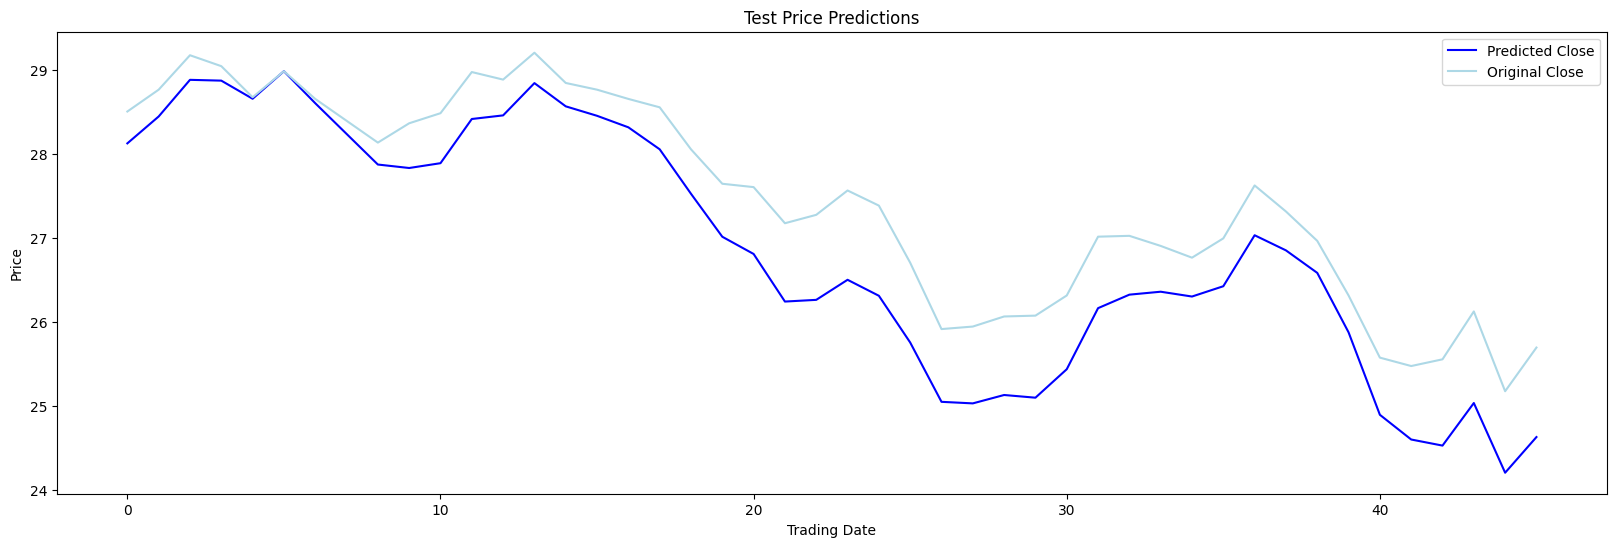

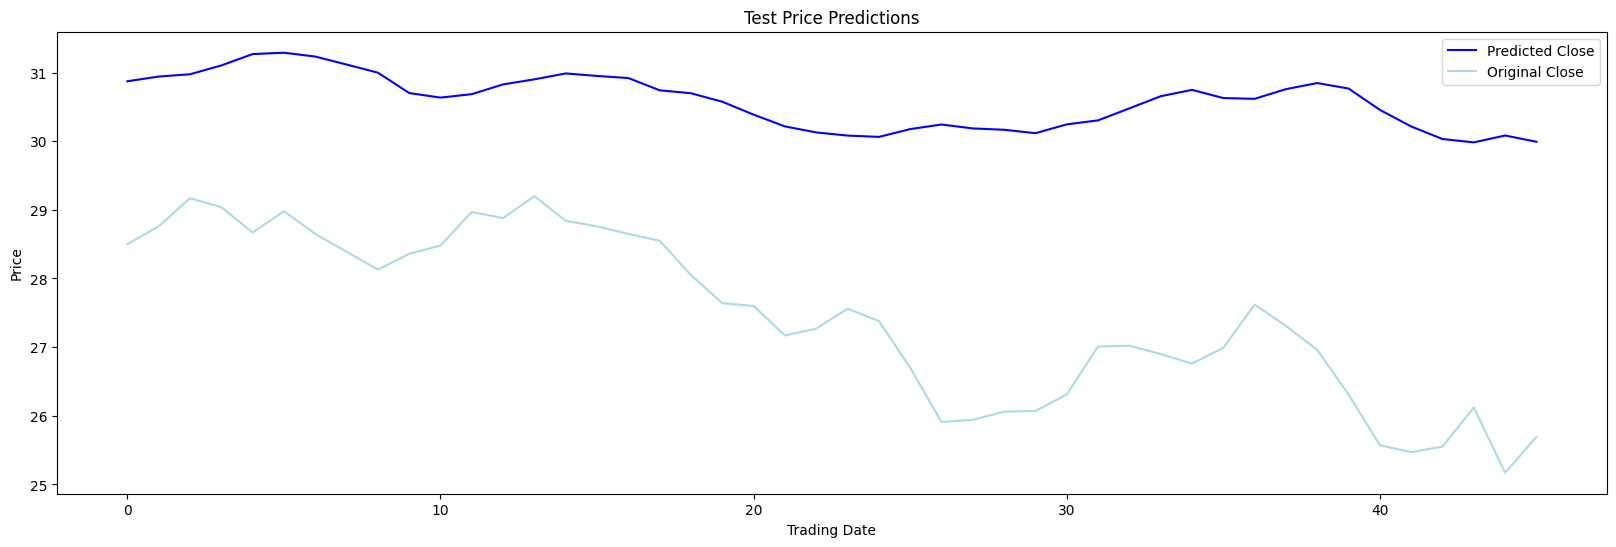

In [15]:
# Plot predicted vs real prices for test data
plt.figure(figsize=(20, 6))
plt.plot(orig[:,0] * predicted_Price[:,0] / max(predicted_Price), color='blue', label=f'Predicted {target_coln}')
plt.plot(orig[:,0], color='lightblue', label=f'Original {target_coln}')
plt.title('Test Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Alternative view of the plot
plt.figure(figsize=(20, 6))
plt.plot(predicted_Price[:,0], color='blue', label=f'Predicted {target_coln}')
plt.plot(orig[:,0], color='lightblue', label=f'Original {target_coln}')
plt.title('Test Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Simplified code full run 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


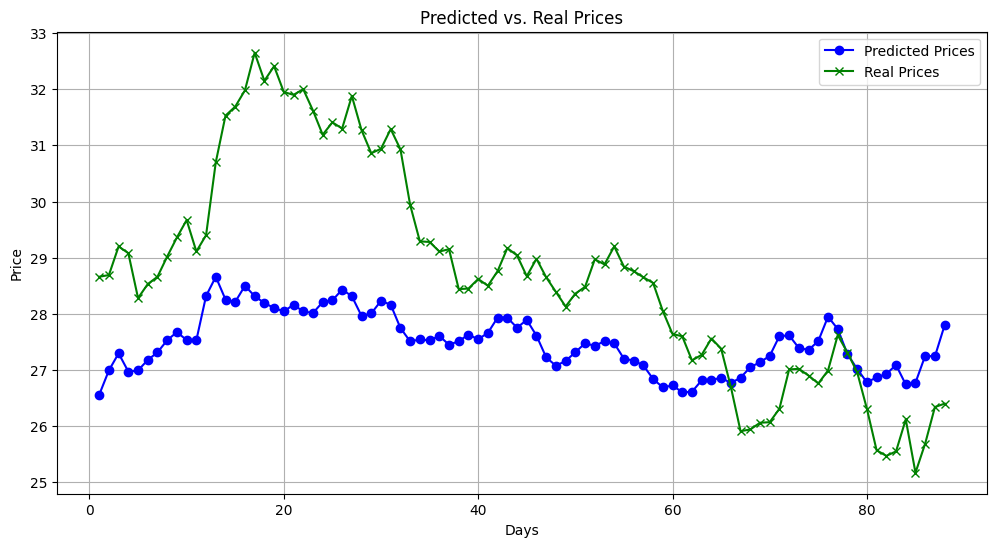

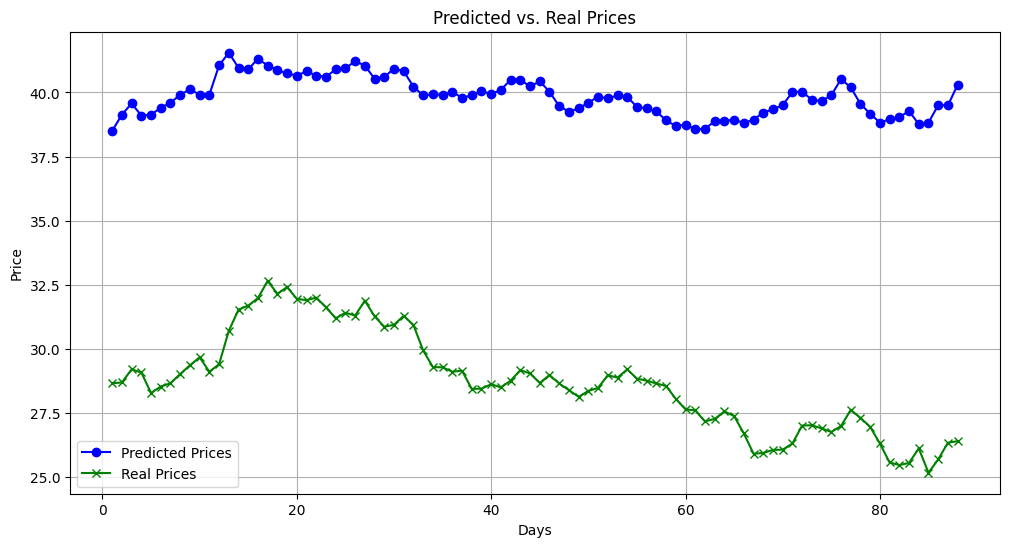

In [17]:
# Load data
data = pd.read_csv('data.csv')

# Parameters
seq_length = 2
target = 'Close'
dayspan = 90

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Split data into train and test sets
train = data.iloc[:-dayspan]
test = data.tail(dayspan)
train.reset_index(drop=True, inplace=True)

# Define target column and features
target_col = target
features = train.columns

# Scale data
scaler = MinMaxScaler()
scaler1 = MinMaxScaler()

X_train = scaler.fit_transform(train[features].values)
y_train = scaler1.fit_transform(train[target_col].values.reshape(-1, 1))
X_test = scaler.transform(test[features].values)
y_test = scaler1.transform(test[target_col].values.reshape(-1, 1))

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, seq_length)
dxx, dyy = create_sequences(X_test, seq_length)

# Build the model
model = Sequential()
model.add(Input(shape=((seq_length, len(features)))))
model.add(LSTM(75, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])

# Train the model with early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
history = model.fit(X_train_seq, y_train_seq, epochs=500, batch_size=128, validation_data=(X_test_seq, y_test_seq), callbacks=[early_stop],verbose=0)

# Inverse transform predictions
scale = MinMaxScaler()
scale.min_, scale.scale_ = scaler.min_[0], scaler.scale_[0]
predbest = scale.inverse_transform(model.predict(dxx)).reshape(-1, 1)
real_prices = test[target_col].values[:-seq_length]

# Plot predicted vs real prices
days = list(range(1, dayspan - seq_length + 1))

plt.figure(figsize=(12, 6))
plt.plot(days, real_prices[0] * predbest / max(predbest), label="Predicted Prices", marker='o', linestyle='-', color='b')
plt.plot(days, real_prices, label="Real Prices", marker='x', linestyle='-', color='g')
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Predicted vs. Real Prices")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(days, predbest, label="Predicted Prices", marker='o', linestyle='-', color='b')
plt.plot(days, real_prices, label="Real Prices", marker='x', linestyle='-', color='g')
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Predicted vs. Real Prices")
plt.legend()
plt.grid(True)
plt.show()